# Reset Kernel and Import Stuff for GradCAM

In [1]:

%matplotlib inline
# All imports
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.io import ImageReadMode
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask
from __future__ import print_function, division
import numpy as np
import pandas as pd
import os

import torch
from skimage import io, transform
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from torchvision import datasets
from torchvision.transforms import ToTensor
import cv2
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, TensorDataset, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torchvision import models
from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryAccuracy, BinaryROC, BinaryAUROC
import PIL
from PIL import Image

# visualisation
import seaborn as sns

# helpers
from tqdm import tqdm
import time
import copy
import gc
from enum import Enum

import warnings
warnings.filterwarnings('ignore')

metadata_list=['mass_case_description_test_set','mass_case_description_train_set']
#'mass_case_description_test_set','mass_case_description_train_set',
df_list=[]
for j in range(len(metadata_list)):
    print (metadata_list[j])
    df=pd.read_csv('C:/Users/marcb/Downloads/'+metadata_list[j]+'.csv')
    print (len(df))
    
    fname=[]
    df=df.rename(columns={"file path": "filename","pathology":"class", 'image file path':'filename'})
    for k in range(len(df)):
        fname.append(df['filename'].loc[k])
        if k>0:
            if fname[k] == fname[k-1]:
                df.drop(k, inplace=True)
    print ('df length after removal of repeats: ', len(df))
    
    for i in range(len(df)):
        df.filename.iloc[i]='C:/Users/marcb/Desktop/CBIS-DDSM-preprocessed/v5_3d/'+df.filename.iloc[i].rsplit('/',3)[0]+'/1-1.png'
        #df.filename[i]='F:/CBIS_DDSM_redo/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM-png/'+df.filename[i].rsplit('/',3)[0]+'/1-1.png'
        if 'MALIGNANT' in df['class'].iloc[i]:
            df['class'].iloc[i]=1
        else:
            df['class'].iloc[i]=0
    df_list.append(df)
#df_list
# df_mass_test=df_list[0]
# df_mass_train=df_list[1]
df_calc_test=df_list[0]
df_calc_train=df_list[1]

# filenames=[]
# labels=[]
# for i in range(len(df_mass_train)):
#     filenames.append(df_mass_train.filename.iloc[i])
#     labels.append(df_mass_train['class'].iloc[i])

# filenames_test=[]
# labels_test=[]
# for i in range(len(df_mass_test)):
#     filenames_test.append(df_mass_test.filename.iloc[i])
#     labels_test.append(df_mass_test['class'].iloc[i])
    
filenames_calc=[]
labels_calc=[]
for i in range(len(df_calc_train)):
    filenames_calc.append(df_calc_train.filename.iloc[i])
    labels_calc.append(df_calc_train['class'].iloc[i])

filenames_test_calc=[]
labels_test_calc=[]
for i in range(len(df_calc_test)):
    filenames_test_calc.append(df_calc_test.filename.iloc[i])
    labels_test_calc.append(df_calc_test['class'].iloc[i])


# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.network = models.resnet50(weights="IMAGENET1K_V1")
#         n_features = self.network.fc.out_features
#         print(n_features)
#         # add additional layer that maps 2048 extracted features from resnet to 1 feature determining the class
#         self.classifier_layer = nn.Sequential(
#             nn.Linear(n_features , 256),
#             nn.Dropout(0.3),
#             nn.Linear(256 , 1)
#         )
    
#     def forward(self, xb):        
#         xb = self.network(xb)
#         xb = self.classifier_layer(xb)
#         return torch.sigmoid(xb)
    
    
# # create class for earlystopping
# class EarlyStopper:
#     def __init__(self, patience=1, min_delta=0):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.counter = 0
#         self.min_loss = np.inf

#     def early_stop(self, loss):
#         if loss <= self.min_loss:
#             self.min_loss = loss
#             self.counter = 0
#         elif loss > (self.min_loss + self.min_delta):
#             self.counter += 1
#             if self.counter >= self.patience:
#                 return True
#         return False
    
    
# def BCELoss_class_weighted(weights):
#     """
#     weights[0] is weight for class 0 (negative class)
#     weights[1] is weight for class 1 (positive class)
#     """
#     def loss(y_pred, target):
#         y_pred = torch.clamp(y_pred,min=1e-7,max=1-1e-7) # for numerical stability
#         bce = - weights[1] * target * torch.log(y_pred) - (1 - target) * weights[0] * torch.log(1 - y_pred)
#         return torch.mean(bce)

#     return loss

# def find_optim_thres(fpr, tpr, thresholds):
#     optim_thres = thresholds[0]
#     inx = 0
#     min_dist = 1.0
#     for i in range(len(fpr)):
#         dist = np.linalg.norm(np.array([0.0, 1.0]) - np.array([fpr[i], tpr[i]]))
#         if dist < min_dist:
#             min_dist = dist
#             optim_thres = thresholds[i]
#             inx = i
            
#     return optim_thres, inx

# model = CNN()
# #model.to(device)
# # convrt weights to cuda.float if cuda is avaliable
# # if torch.cuda.is_available():
# #    model.cuda()

# # defining the optimizer
# # optimizer = Adam(model.parameters(), lr=5e-4)
# # scheduler = StepLR(optimizer, step_size=4, gamma=0.2)
# PATH='C:/Users/marcb/Desktop/pytorch_models/resnet50_10epoch_calc'
# model.load_state_dict(torch.load(PATH),strict=False)

mass_case_description_test_set
378
df length after removal of repeats:  361
mass_case_description_train_set
1318
df length after removal of repeats:  1231


In [6]:
#model=my_resnet50()
PATH_m='C:/Users/marcb/Desktop/pytorch_models/models/SEresnet50_40epoch_masss_baseline_4th_model'
PATH_w='C:/Users/marcb/Desktop/pytorch_models/weights/SEresnet50_40epoch_masss_baseline_4th_model'
model = torch.load(PATH_m).eval()
# from torchvision.models import resnet50
# 
model.load_state_dict(torch.load(PATH_w),strict=False)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/marcb/Desktop/pytorch_models/weights/SEresnet50_40epoch_masss_baseline_4th_model'

# Calc Activation Maps and Save Images

In [7]:
class MammographyPreprocessor():
    
    # Constructor
    def __init__(self, size: tuple=None, breast_side: str='L',
                 csv_path=None, train_path=None):
        self.size = size
        os.makedirs(os.getcwd(), exist_ok=True)
        self.breast_side = breast_side
        assert breast_side in ['L', 'R'], "breast_side should be 'L' or 'R'"
        # implement the paths of the original RSNA dataset (V2)
#         self.csv_path = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
#         self.train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'
#         if csv_path:
#             self.csv_path = csv_path
#         if train_path:
#             self.train_path = train_path
#         self.df = pd.read_csv(self.csv_path)
        self.save_root = os.getcwd()
    
#     # Get the paths from the preprocessor (V2)
#     def get_paths(self, n: int=None, shuffle: bool=False, return_cache: bool=False):
#         if n == None:
#             n = len(self.df)
#         if shuffle == True:
#             df = self.df.sample(frac=1, random_state=0).copy()
#         else:
#             df = self.df.copy()
#         paths = []
#         ids_cache = []
#         for i in range(n):
#             patient = str(df.iloc[i]['patient_id'])
#             scan = str(df.iloc[i]['image_id'])
#             paths.append(self.train_path + '/' + patient + '/' + scan + '.dcm')
#             ids_cache.append({'patient_id': patient, 'scan_id': scan})
#         if return_cache:
#             return paths, ids_cache
#         else:
#             return paths
    
    # Read from a path and convert to image array
    def read_image(self, path: str):
        scan = pydicom.dcmread(path)
        img = scan.pixel_array
        return img
    
    # Apply the preprocessing methods on one image
    
    def preprocess_single_image2(self,img,  save: bool=False,
                                save_dir: str=None, png: bool=True):
#         scan = dicomsdl.open(path)
#         img = scan.pixelData()
        dim=(img.shape[0],img.shape[1])
        n=.06
        img = img-np.min(img)
        img = self._normalize_to_255(img)
        #img=255*(img/np.max(img))
        img = img[int(0+dim[0]*n):int(dim[0]-dim[0]*n),int(0+dim[1]*n):int(dim[1]-dim[1]*n)].astype('uint8')
        breast_mask=segment_breast(img,low_int_threshold=1, crop=True)
        img= self._flip_breast_side2(img)
        img, y1,y2,x1,x2 = self._crop(img)
        clahe = cv2.createCLAHE(clipLimit = 5,tileGridSize=(8,8))
        img = clahe.apply(img[:,:,0])        
        if self.size:
            img = self._resize2(img)
        img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
        img=np.expand_dims(img, 2)
        img=np.tile(img, [1,1,3])
        img[img<=3]=0
        return img 
        
        
    def preprocess_single_image(self,img,mask,mask2,mask_num,  save: bool=False,
                                save_dir: str=None, png: bool=True):
#         scan = dicomsdl.open(path)
#         img = scan.pixelData()
        dim=(img.shape[0],img.shape[1])
        n=.06
        img = img-np.min(img)
        img = self._normalize_to_255(img)
        img_copy=np.ndarray.copy(img)
        #img=255*(img/np.max(img))
        img = img[int(0+dim[0]*n):int(dim[0]-dim[0]*n),int(0+dim[1]*n):int(dim[1]-dim[1]*n)].astype('uint8')
        if mask_num == 0:
            mask = 0
        elif mask_num >= 1:
            mask = mask[int(0+dim[0]*n):int(dim[0]-dim[0]*n),int(0+dim[1]*n):int(dim[1]-dim[1]*n)]
            #print (mask.dtype, mask)
            breast_mask=segment_breast(img,low_int_threshold=1, crop=True)
            img, mask = self._flip_breast_side(img,mask)
            img, y1,y2,x1,x2  = self._crop(img)
            mask = mask[y1:y2,x1:x2] 
            #print (img.dtype, img.shape)
            clahe = cv2.createCLAHE(clipLimit = 5,tileGridSize=(8,8))
            img = clahe.apply(img[:,:,0]) 
#             print (mask.dtype, mask)
            if self.size:
                img, mask = self._resize(img,mask)
            img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
            img=np.expand_dims(img, 2)
            img=np.tile(img, [1,1,3])
            img[img<=3]=0
            if mask_num == 1:
                return img, mask
            else:
                mask2 = mask2[int(0+dim[0]*n):int(dim[0]-dim[0]*n),int(0+dim[1]*n):int(dim[1]-dim[1]*n)]
                breast_mask=segment_breast(img_copy,low_int_threshold=1, crop=True)
                img_copy, mask2 = self._flip_breast_side(img_copy,mask2)
                img_copy, y1,y2,x1,x2 = self._crop(img_copy)
                mask2 = mask2[y1:y2,x1:x2]      
                if self.size:
                    img_copy,mask2 = self._resize(img_copy,mask2)
                return img, mask, mask2
        
            
            
    
    # Preprocess all the images from the paths
    def preprocess_all(self, paths: list, save: bool=True,
                       save_dir: str='train_images', png: bool=True,
                       parallel: bool=False, n_jobs: int=4):
        clock = time.time()
        if parallel:
            Parallel(n_jobs=n_jobs) \
            (delayed(self.preprocess_single_image) \
            (path, save, save_dir, png) for path in tqdm(paths, total=len(paths)))
            print("Parallel preprocessing done!")
        else:
            for i in trange(len(paths)):
                self.preprocess_single_image(paths[i], save, save_dir, png)
            print("Sequential preprocessing done!")
        print("Time =", np.around(time.time() - clock, 3), 'sec')
    
    # Display the images from the dicom paths with optional preprocessing
    def display(self, paths: list, rows: int, cols: int,
                preprocess: bool=False, cmap='bone', cbar: bool=False,
                save_fig: bool=False, save_name: str='myplot.png'):
        assert len(paths) >= (rows * cols), \
        f"Not enough paths for the display. " \
        f"Please give at least {rows * cols} paths."
        plt.figure(figsize=(18, 26 * rows / cols))
        for i in trange(rows * cols):
            path = paths[i]
            if preprocess:
                img = self.preprocess_single_image(path, save=False)
            else:
                img = self.read_image(path)
            plt.subplot(rows, cols, i+1)
            plt.imshow(img, cmap=cmap)
            if cbar:
                plt.colorbar()
            plt.grid(False)
            plt.title(path.split('/')[-1][:-4])
        plt.suptitle("Preprocessed images" if preprocess \
                     else "Raw images", fontsize=25)
        if save_fig:
            plt.savefig(save_name, facecolor='white')
        plt.show()
    
    # Adjust the contrast of an image
    def _windowing(self, img, scan):
        center = (2**8-1)-60
        width = 60
        bits_stored = scan.BitsStored
        function = scan.VOILUTFunction
        if isinstance(center, list):
            center = center[0]
        if isinstance(width, list):
            width = width[0] 
        y_range = float(2**bits_stored - 1)
        if function == 'SIGMOID':
            img = y_range / (1 + np.exp(-4 * (img - center) / width))
        else: # LINEAR
            center -= 0.5
            width -= 1
            below = img <= (center - width / 2)
            above = img > (center + width / 2)
            between = np.logical_and(~below, ~above)
            img[below] = 0
            img[above] = y_range
            img[between] = ((img[between] - center) / width + 0.5) * y_range
        return img
    
    # Interpret pixels in a consistant way
    def _fix_photometric_interpretation(self, img, scan):
        if scan.PhotometricInterpretation == 'MONOCHROME1':
            return img.max() - img
        elif scan.PhotometricInterpretation == 'MONOCHROME2':
            return img - img.min()
        else:
            raise ValueError("Invalid Photometric Interpretation: {}"
                               .format(scan.PhotometricInterpretation))
    
    # Cast into 8-bits for saving
    def _normalize_to_255(self, img):
        if img.max() != 0:
            img = img / img.max()
        img *= 255
        return img.astype(np.uint8)
    
    # Flip the breast horizontally on the chosen side 
    def _flip_breast_side(self, img,mask):
        img_breast_side = self._determine_breast_side(img)
        if img_breast_side == self.breast_side:
            return img, mask
        else:
            return np.fliplr(img) ,np.fliplr(mask)  
    
    def _flip_breast_side2(self, img):
        img_breast_side = self._determine_breast_side(img)
        if img_breast_side == self.breast_side:
            return img
        else:
            return np.fliplr(img) 
    
    # Determine the current breast side
    def _determine_breast_side(self, img):
        col_sums_split = np.array_split(np.sum(img, axis=0), 2)
        left_col_sum = np.sum(col_sums_split[0])
        right_col_sum = np.sum(col_sums_split[1])
        if left_col_sum > right_col_sum:
            return 'L'
        else:
            return 'R'
    
    # Crop the useless background of the image
    def _crop(self, img):
        bin_img = self._binarize(img[:,:,0], threshold=1)
        contour = self._extract_contour(bin_img)
        img = self._erase_background(img, contour)
        x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
        y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
        x1, x2 = int(0.98 * x1), int(1.02 * x2)
        y1, y2 = int(0.98 * y1), int(1.02 * y2)
        return img[y1:y2, x1:x2],y1,y2,x1,x2
#         except:
#             print ('crop didnt work')
#             return img,0,img.shape[0],0,img.shape[1]
    
    # Binarize the image at the threshold
    def _binarize(self, img, threshold):
        return (img > threshold).astype(np.uint8)
    
    # Get contour points of the breast
    def _extract_contour(self, bin_img):
        contours, _ = cv2.findContours(
            bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contour = max(contours, key=cv2.contourArea)
        return contour
    
    # Set to background pixels of the image to zero
    def _erase_background(self, img, contour):
        mask = np.zeros(img.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
        output = cv2.bitwise_and(img, mask)
        return output
    
    # Resize the image to the preprocessor size
    def _resize2(self, img):
        return cv2.resize(img, self.size, interpolation=cv2.INTER_AREA)
    
    def _resize(self, img, mask):
        return cv2.resize(img, self.size, interpolation=cv2.INTER_AREA), cv2.resize(np.array(mask), self.size, interpolation=cv2.INTER_AREA)
    
import cv2
import numpy as np





def select_largest_obj(img_bin, lab_val=255, fill_holes=False, 
                       smooth_boundary=False, kernel_size=15):
    '''Select the largest object from a binary image and optionally
    fill holes inside it and smooth its boundary.
    Args:
        img_bin (2D array): 2D numpy array of binary image.
        lab_val ([int]): integer value used for the label of the largest 
                object. Default is 255.
        fill_holes ([boolean]): whether fill the holes inside the largest 
                object or not. Default is false.
        smooth_boundary ([boolean]): whether smooth the boundary of the 
                largest object using morphological opening or not. Default 
                is false.
        kernel_size ([int]): the size of the kernel used for morphological 
                operation. Default is 15.
    Returns:
        a binary image as a mask for the largest object.
    '''
    n_labels, img_labeled, lab_stats, _ = \
        cv2.connectedComponentsWithStats(img_bin, connectivity=8, 
                                         ltype=cv2.CV_32S)
    largest_obj_lab = np.argmax(lab_stats[1:, 4]) + 1
    largest_mask = np.zeros(img_bin.shape, dtype=np.uint8)
    largest_mask[img_labeled == largest_obj_lab] = lab_val
    # import pdb; pdb.set_trace()
    if fill_holes:
        bkg_locs = np.where(img_labeled == 0)
        bkg_seed = (bkg_locs[0][0], bkg_locs[1][0])
        img_floodfill = largest_mask.copy()
        h_, w_ = largest_mask.shape
        mask_ = np.zeros((h_ + 2, w_ + 2), dtype=np.uint8)
        cv2.floodFill(img_floodfill, mask_, seedPoint=bkg_seed, 
                      newVal=lab_val)
        holes_mask = cv2.bitwise_not(img_floodfill)  # mask of the holes.
        largest_mask = largest_mask + holes_mask
    if smooth_boundary:
        kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
        largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_OPEN, 
                                        kernel_)

    return largest_mask


def max_pix_val(dtype):
    if dtype == np.dtype('uint8'):
        maxval = 2**8 - 1
    elif dtype == np.dtype('uint16'):
        maxval = 2**16 - 1
    else:
        raise Exception('Unknown dtype found in input image array')
    return maxval


def suppress_artifacts( img, global_threshold=.05, fill_holes=False, 
                       smooth_boundary=True, kernel_size=15):
    '''Mask artifacts from an input image
    Artifacts refer to textual markings and other small objects that are 
    not related to the breast region.
    Args:
        img (2D array): input image as a numpy 2D array.
        global_threshold ([int]): a global threshold as a cutoff for low 
                intensities for image binarization. Default is 18.
        kernel_size ([int]): kernel size for morphological operations. 
                Default is 15.
    Returns:
        a tuple of (output_image, breast_mask). Both are 2D numpy arrays.
    '''
    maxval = max_pix_val(img.dtype)
    if global_threshold < 1.:
        low_th = int(img.max()*global_threshold)
    else:
        low_th = int(global_threshold)
    _, img_bin = cv2.threshold(img, low_th, maxval=maxval, 
                               type=cv2.THRESH_BINARY)
    breast_mask = select_largest_obj(img_bin, lab_val=maxval, 
                                          fill_holes=True, 
                                          smooth_boundary=True, 
                                          kernel_size=kernel_size)
    img_suppr = cv2.bitwise_and(img, breast_mask)

    return img_suppr


def segment_breast(img, low_int_threshold=.05, crop=True):
    '''Perform breast segmentation
    Args:
        low_int_threshold([float or int]): Low intensity threshold to 
                filter out background. It can be a fraction of the max 
                intensity value or an integer intensity value.
        crop ([bool]): Whether or not to crop the image.
    Returns:
        An image of the segmented breast.
    NOTES: the low_int_threshold is applied to an image of dtype 'uint8',
        which has a max value of 255.
    '''
    # Create img for thresholding and contours.
    img=img[:,:,0]
    img_8u = ((img.astype('float32')/img.max())*255).astype('uint8')
    if low_int_threshold < 1.:
        low_th = int(img_8u.max()*low_int_threshold)
    else:
        low_th = int(low_int_threshold)
    _, img_bin = cv2.threshold(
        img_8u, low_th, maxval=255, type=cv2.THRESH_BINARY)
    ver = (cv2.__version__).split('.')
    if int(ver[0]) < 3:
        contours,_ = cv2.findContours(
            img_bin.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours,_ = cv2.findContours(
            img_bin.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cont_areas = [ cv2.contourArea(cont) for cont in contours ]
    idx = np.argmax(cont_areas)  # find the largest contour, i.e. breast.
    breast_mask = cv2.drawContours(
        np.zeros_like(img_bin), contours, idx, 255, -1)  # fill the contour.
#     # segment the breast.
#     img_breast_only = cv2.bitwise_and(img, img, mask=breast_mask)
#     x,y,w,h = cv2.boundingRect(contours[idx])
#     if crop:
#         img_breast_only = img_breast_only[y:y+h, x:x+w]
    return  breast_mask


def remove_pectoral( img, breast_mask, high_int_threshold=.8, 
                    morph_kn_size=3, n_morph_op=7, sm_kn_size=25):
    '''Remove the pectoral muscle region from an input image
    Args:
        img (2D array): input image as a numpy 2D array.
        breast_mask (2D array):
        high_int_threshold ([int]): a global threshold for high intensity 
                regions such as the pectoral muscle. Default is 200.
        morph_kn_size ([int]): kernel size for morphological operations 
                such as erosions and dilations. Default is 3.
        n_morph_op ([int]): number of morphological operations. Default is 7.
        sm_kn_size ([int]): kernel size for final smoothing (i.e. opening). 
                Default is 25.
    Returns:
        an output image with pectoral muscle region removed as a numpy 
        2D array.
    Notes: this has not been tested on .dcm files yet. It may not work!!!
    '''
    # Enhance contrast and then thresholding.
    img_equ = cv2.equalizeHist(img)
    if high_int_threshold < 1.:
        high_th = int(img.max()*high_int_threshold)
    else:
        high_th = int(high_int_threshold)
    maxval = max_pix_val(img.dtype)
    _, img_bin = cv2.threshold(img_equ, high_th, 
                               maxval=maxval, type=cv2.THRESH_BINARY)
    pect_marker_img = np.zeros(img_bin.shape, dtype=np.int32)
    # Sure foreground (shall be pectoral).
    pect_mask_init = select_largest_obj(img_bin, lab_val=maxval, 
                                             fill_holes=True, 
                                             smooth_boundary=False)
    kernel_ = np.ones((morph_kn_size, morph_kn_size), dtype=np.uint8)
    pect_mask_eroded = cv2.erode(pect_mask_init, kernel_, 
                                 iterations=n_morph_op)
    pect_marker_img[pect_mask_eroded > 0] = 255
    # Sure background - breast.
    pect_mask_dilated = cv2.dilate(pect_mask_init, kernel_, 
                                   iterations=n_morph_op)
    pect_marker_img[pect_mask_dilated == 0] = 128
    # Sure background - pure background.
    pect_marker_img[breast_mask == 0] = 64
    # Watershed segmentation.
    img_equ_3c = cv2.cvtColor(img_equ, cv2.COLOR_GRAY2BGR)
    cv2.watershed(img_equ_3c, pect_marker_img)
    img_equ_3c[pect_marker_img == -1] = (0, 0, 255)
    # Extract only the breast and smooth.
    breast_only_mask = pect_marker_img.copy()
    breast_only_mask[breast_only_mask == -1] = 0
    breast_only_mask = breast_only_mask.astype(np.uint8)
    breast_only_mask[breast_only_mask != 128] = 0
    breast_only_mask[breast_only_mask == 128] = 255
    kernel_ = np.ones((sm_kn_size, sm_kn_size), dtype=np.uint8)
    breast_only_mask = cv2.morphologyEx(breast_only_mask, cv2.MORPH_OPEN, 
                                        kernel_)
    img_breast_only = cv2.bitwise_and(img_equ, breast_only_mask)

    return (img_breast_only)


def process(self, img, median_filtering=True, blur_kn_size=3, 
            artif_suppression=True, low_int_threshold=.05, kernel_size=15,
            pect_removal=False, high_int_threshold=.8, **pect_kwargs):
    '''Perform multi-stage preprocessing on the input image
    Args:
        blur_kn_size ([int]): kernel size for median blurring.
        low_int_threshold ([int]): cutoff used in artifacts suppression.
        high_int_threshold ([int]): cutoff used in pectoral muscle removal.
    Returns:
        a tuple of (processed_image, color_image_with_boundary). If 
        pectoral removal was not called, the color image is None.
    '''
    img_proc = img.copy()
    if median_filtering:
        img_proc = cv2.medianBlur(img_proc, blur_kn_size)
    if artif_suppression:
        img_proc, mask_ = self.suppress_artifacts(
            img_proc, global_threshold=low_int_threshold, 
            kernel_size=kernel_size)
    else:
        _, mask_ = self.suppress_artifacts(img_proc)
    if pect_removal:
        img_proc, img_col = self.remove_pectoral(
            img_proc, mask_, high_int_threshold=high_int_threshold, 
            **pect_kwargs)
    else:
        img_col = None

    return (img_proc, img_col)

In [11]:
# cam_extractor = SmoothGradCAMpp(model, target_layer=['network.layer4','network.layer3','network.layer2'])
layer_list=['layer4','layer3','layer2']
# Get your input
from torchcam.methods import GradCAMpp
CAM = GradCAMpp(model, layer_list)
device='cuda'


import os
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow import keras
from PIL import Image as pil
colormap='jet'

mp = MammographyPreprocessor(size=(300, 500))
dim=(500,300)
n=.1
count=0
alpha=.5
TPc=0
TNc=0
FNc=0
FPc=0

mask_folders_path='F:/CBIS_DDSM_redo/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM-mask/'
mask_folders=os.listdir(mask_folders_path)
folders_path = "F:/CBIS_DDSM_redo/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM-png/"
folders=os.listdir(folders_path)

for folder in folders:
    m = 0
    if "Mass" in folder:
        if "Test" in folder:
            count=count+1
            
            if count>100:
                img_path=os.path.join(folders_path, folder,'1-1.png')
                img = cv2.imread(img_path)
    #             img = resize(img, (dim[0], dim[1]))
    #             img = img[:,int(0+dim[0]*n):int(dim[0]-dim[0]*n),int(0+dim[1]*n):int(dim[1]-dim[1]*n)]
                if folder+'_1' in mask_folders:
                    if folder+'_2' in mask_folders:
                        folder1=os.listdir(os.path.join(mask_folders_path, folder+'_1'))
                        folder2=os.listdir(os.path.join(mask_folders_path, folder+'_1/',folder1[0]))
                        mask_path = os.path.join(mask_folders_path, folder+'_1/',folder1[0],folder2[0],'1-2.png')
                        folder1_2=os.listdir(os.path.join(mask_folders_path, folder+'_2'))
                        folder2_2=os.listdir(os.path.join(mask_folders_path, folder+'_2/',folder1_2[0]))
                        mask2_path = os.path.join(mask_folders_path, folder+'_2/',folder1_2[0],folder2_2[0],'1-2.png')
                        mask = cv2.imread(mask_path)
                        mask2 = cv2.imread(mask2_path)
                        img, mask, mask2 = mp.preprocess_single_image(img,mask,mask2,2,save=False)
                        m = 1
                    else:
                        folder1=os.listdir(os.path.join(mask_folders_path, folder+'_1'))
                        folder2=os.listdir(os.path.join(mask_folders_path, folder+'_1/',folder1[0]))
                        mask_path = os.path.join(mask_folders_path, folder+'_1/',folder1[0],folder2[0],'1-2.png')
                        mask =  cv2.imread(mask_path)
                        img, mask = mp.preprocess_single_image(img,mask,0,1,save=False)
                        m = 1

                elif folder+'_2' in mask_folders:
                    folder1=os.listdir(os.path.join(mask_folders_path, folder+'_2'))
                    folder2=os.listdir(os.path.join(mask_folders_path, folder+'_2/',folder1[0]))
                    mask_path = os.path.join(mask_folders_path, folder+'_2/',folder1[0],folder2[0],'1-2.png')
                    mask =  cv2.imread(mask_path)
                    img, mask = mp.preprocess_single_image(img,mask,0,1,save=False)
                    m = 1


                else:
                    mask=0
                    img=mp.preprocess_single_image2(img,save=False)
                    m = 0
                    print ('No mask for ', folder)
                
                

                input_tensor=torch.Tensor(img)
                input_tensor=input_tensor.permute(2,0,1)
                input_tensor=input_tensor/torch.max(input_tensor)
#                 input_tensor = torchvision.transforms.ToPILImage()(input_tensor.to('cpu'))
#                 input_tensor = torchvision.transforms.ToTensor()(input_tensor).float()
                #input_tensor=input_tensor.permute(2,0,1)
                
                input_tensor=input_tensor.to(device)
                out = model(input_tensor.unsqueeze(0))
                #cams = cam_extractor(out.squeeze(0).argmax().item(), out)
                scores = model(input_tensor.unsqueeze(0))
                cams=CAM(class_idx=0, scores=scores)
                for name, cam in zip(layer_list, cams):
                    if labels_test_calc[count] == 1 :
                        if out.squeeze(0).item()<=.5:
                            val='Benign Prediction for Malignant Truth'
                            v='_FN'
                            FNc=FNc+1
                        else:
                            val='Malignant Prediction for Malignant Truth'
                            v='_TP'
                            TPc=TPc+1
                    else:
                        if out.squeeze(0).item()<=.5:
                            val='Benign Prediction for Benign Truth'
                            v='_TN'
                            TNc=TNc+1
                        else:
                            val='Malignant Prediction for Benign Truth'
                            v='_FP'
                            FPc=FPc+1
                    cam_path=os.path.join('C:/Users/marcb/Desktop/GradCAM/newformat/',folder,'cv_layer'+name[-1]+v+'.jpg')
    #                 cam_path_mask=os.path.join('C:/Users/marcb/Desktop/GradCAM/',folder,'Mask_cv_layer'+name[-1]+v+'.jpg')
    #                 cam_path_mask2=os.path.join('C:/Users/marcb/Desktop/GradCAM/',folder,'Mask2_cv_layer'+name[-1]+v+'.jpg')
                    try:
                        os.makedirs(os.path.join('C:/Users/marcb/Desktop/GradCAM/newformat/',folder))
                    except:
                        continue


                    cam_im=np.array(cam.squeeze(0).cpu())
                    alpha=.7
                    cmap = cm.get_cmap(colormap)
                    # Resize mask and apply colormap
                    overlay = cv2.resize(cam_im,(img.shape[1],img.shape[0]))
                    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
                    # Overlay the image with the mask
                    overlayed_img =(alpha * np.asarray(img) + (1 - alpha) * overlay).astype(np.uint8)
                    if folder+'_1' in mask_folders:
                        if folder+'_2' in mask_folders:
                            overlayed_img[:,:,0] = .5*overlayed_img[:,:,0]+100*mask[:,:,0]+100*mask2[:,:,0]
                            overlayed_img[:,:,1] = .5*overlayed_img[:,:,1]+100*mask[:,:,0]+100*mask2[:,:,0]
                            overlayed_img[:,:,2] = .5*overlayed_img[:,:,2]+100*mask[:,:,0]+100*mask2[:,:,0]
                        else:                    
                            overlayed_img[:,:,0] = .5*overlayed_img[:,:,0]+100*mask[:,:,0]
                            overlayed_img[:,:,1] = .5*overlayed_img[:,:,1]+100*mask[:,:,0]
                            overlayed_img[:,:,2] = .5*overlayed_img[:,:,2]+100*mask[:,:,0]
                    elif folder+'_2' in mask_folders:
                        overlayed_img[:,:,0] = .5*overlayed_img[:,:,0]+100*mask2[:,:,0]
                        overlayed_img[:,:,1] = .5*overlayed_img[:,:,1]+100*mask2[:,:,0]
                        overlayed_img[:,:,2] = .5*overlayed_img[:,:,2]+100*mask2[:,:,0]
                    else:
                        overlayed_img = overlayed_img
                    #print ('break here')
                        

#                     plt.imshow(overlayed_img)
#                     plt.savefig(cam_path)
                    im_final = pil.fromarray(overlayed_img, "RGB")
                    im_final.save(cam_path)
                    #count=count+1


    #                 overlayed_img.save(cam_path)

    #                 if folder+'_1' in mask_folders:
    #                     result_mask = overlay_mask(to_pil_image(img), to_pil_image(mask, mode='F'), alpha=0.6)                       
    #                     plt.imshow(result_mask); plt.axis('off'); plt.title(name+'for '+folder+' - Mask - '+val); plt.show()
    #                     result_mask.save(cam_path_mask)



                
            

# out = model(input_tensor.unsqueeze(0))
# # Retrieve the CAM by passing the class index and the model output
# cams = cam_extractor(out.squeeze(0).argmax().item(), out)

KeyboardInterrupt: 

In [ ]:
TPc

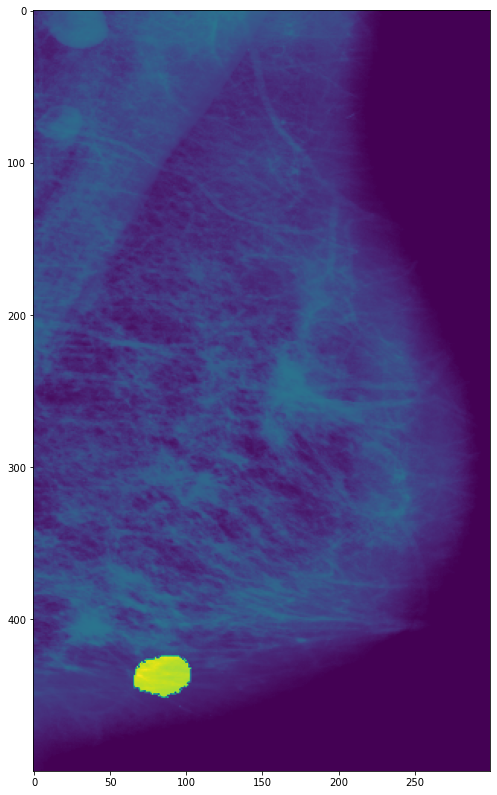

In [25]:
from matplotlib.pyplot import figure
plt.figure(figsize=(14,14))
cam_im=to_pil_image(cam.squeeze(0), mode='F')
superimposed_img =  .5*img[:,:,0] + 10*mask[:,:,0]
#superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)   
plt.imshow(superimposed_img)


In [67]:
from matplotlib import cm
colormap='jet'
# input_tensor=torch.Tensor(img).permute(2,0,1)
# out = model(input_tensor.unsqueeze(0).to(device))
# cams = cam_extractor(out.squeeze(0).argmax().item(), out)
cam_im=np.array(cam.squeeze(0))
alpha=.7
cmap = cm.get_cmap(colormap)
# Resize mask and apply colormap
overlay = cv2.resize(cam_im,(img.shape[1],img.shape[0]))
overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
# Overlay the image with the mask
overlayed_img =(alpha * np.asarray(img) + (1 - alpha) * overlay).astype(np.uint8)
overlayed_img[:,:,0] = .5*overlayed_img[:,:,0]+100*mask[:,:,0]
overlayed_img[:,:,1] = .5*overlayed_img[:,:,1]+100*mask[:,:,0]
overlayed_img[:,:,2] = .5*overlayed_img[:,:,2]+100*mask[:,:,0]

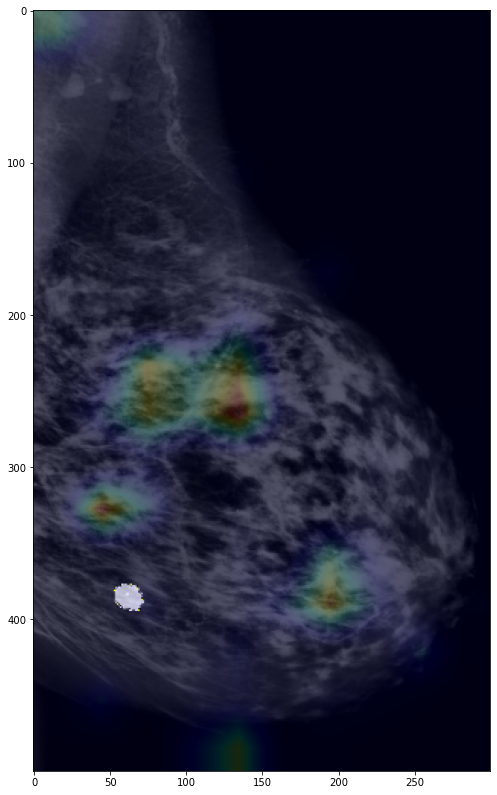

In [69]:
plt.figure(figsize=(14,14))

plt.imshow(overlayed_img)


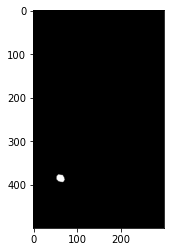

In [57]:
plt.imshow(mask)

# Squeeze and Excitation

In [4]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torch
import torch.nn as nn
from torch import Tensor

from torchvision.transforms._presets import ImageClassification
from torchvision.utils import _log_api_usage_once
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._meta import _IMAGENET_CATEGORIES
from torchvision.models._utils import _ovewrite_named_param, handle_legacy_interface

class SElayer(nn.Module):
    def __init__(self, inplanes, reduction=16):
        super(SElayer,self).__init__()
        self.globalAvgpool = nn.AdaptiveAvgPool2d(1)#Squeeze操作
        self.fc1 = nn.Conv2d(inplanes, inplanes // reduction, kernel_size=1, stride=1)
        self.fc2 = nn.Conv2d(inplanes // reduction, inplanes, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        begin_input = x
        x = self.globalAvgpool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x * begin_input

# ResNet50 + Squeeze and Excitation

In [5]:
__all__ = [
    "ResNet",
    "ResNet18_Weights",
    "ResNet34_Weights",
    "ResNet50_Weights",
    "ResNet101_Weights",
    "ResNet152_Weights",
    "ResNeXt50_32X4D_Weights",
    "ResNeXt101_32X8D_Weights",
    "ResNeXt101_64X4D_Weights",
    "Wide_ResNet50_2_Weights",
    "Wide_ResNet101_2_Weights",
    "resnet18",
    "resnet34",
    "resnet50",
    "resnet101",
    "resnet152",
    "resnext50_32x4d",
    "resnext101_32x8d",
    "resnext101_64x4d",
    "wide_resnet50_2",
    "wide_resnet101_2",
]


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.selayer = SElayer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.selayer(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        l1=256, l2=64,l3=.3,
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.classifier_layer = nn.Sequential(
            nn.Linear(2048  , 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            #nn.Dropout(.2),
            nn.Linear(256 , 1),
#             nn.BatchNorm1d(256),
#             nn.ReLU(inplace=True),
#             #nn.Dropout(0.4),
#             nn.Linear(256 , 1),
#             nn.BatchNorm1d(128),
#             nn.LeakyReLU(.1),
#             nn.Dropout(0.6),
#             nn.Linear(256 , 1)
        )
        

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
#         x = self.fc(x)
        x = self.classifier_layer(x)

        return torch.sigmoid(x)

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights: Optional[WeightsEnum],
    progress: bool,
    **kwargs: Any,
) -> ResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet(block, layers, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress),strict=False)

    return model


_COMMON_META = {
    "min_size": (1, 1),
    "categories": _IMAGENET_CATEGORIES,
}


class ResNet18_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnet18-f37072fd.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 11689512,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnet",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 69.758,
                    "acc@5": 89.078,
                }
            },
            "_ops": 1.814,
            "_file_size": 44.661,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    DEFAULT = IMAGENET1K_V1


class ResNet34_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnet34-b627a593.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 21797672,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnet",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 73.314,
                    "acc@5": 91.420,
                }
            },
            "_ops": 3.664,
            "_file_size": 83.275,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    DEFAULT = IMAGENET1K_V1


class ResNet50_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnet50-0676ba61.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 25557032,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnet",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 76.130,
                    "acc@5": 92.862,
                }
            },
            "_ops": 4.089,
            "_file_size": 97.781,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/resnet50-11ad3fa6.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 25557032,
            "recipe": "https://github.com/pytorch/vision/issues/3995#issuecomment-1013906621",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 80.858,
                    "acc@5": 95.434,
                }
            },
            "_ops": 4.089,
            "_file_size": 97.79,
            "_docs": """
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2


class ResNet101_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnet101-63fe2227.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 44549160,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnet",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 77.374,
                    "acc@5": 93.546,
                }
            },
            "_ops": 7.801,
            "_file_size": 170.511,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/resnet101-cd907fc2.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 44549160,
            "recipe": "https://github.com/pytorch/vision/issues/3995#new-recipe",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 81.886,
                    "acc@5": 95.780,
                }
            },
            "_ops": 7.801,
            "_file_size": 170.53,
            "_docs": """
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2


class ResNet152_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnet152-394f9c45.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 60192808,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnet",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 78.312,
                    "acc@5": 94.046,
                }
            },
            "_ops": 11.514,
            "_file_size": 230.434,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/resnet152-f82ba261.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 60192808,
            "recipe": "https://github.com/pytorch/vision/issues/3995#new-recipe",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 82.284,
                    "acc@5": 96.002,
                }
            },
            "_ops": 11.514,
            "_file_size": 230.474,
            "_docs": """
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2


class ResNeXt50_32X4D_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 25028904,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnext",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 77.618,
                    "acc@5": 93.698,
                }
            },
            "_ops": 4.23,
            "_file_size": 95.789,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 25028904,
            "recipe": "https://github.com/pytorch/vision/issues/3995#new-recipe",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 81.198,
                    "acc@5": 95.340,
                }
            },
            "_ops": 4.23,
            "_file_size": 95.833,
            "_docs": """
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2


class ResNeXt101_32X8D_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 88791336,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnext",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 79.312,
                    "acc@5": 94.526,
                }
            },
            "_ops": 16.414,
            "_file_size": 339.586,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/resnext101_32x8d-110c445d.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 88791336,
            "recipe": "https://github.com/pytorch/vision/issues/3995#new-recipe-with-fixres",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 82.834,
                    "acc@5": 96.228,
                }
            },
            "_ops": 16.414,
            "_file_size": 339.673,
            "_docs": """
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2


class ResNeXt101_64X4D_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 83455272,
            "recipe": "https://github.com/pytorch/vision/pull/5935",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 83.246,
                    "acc@5": 96.454,
                }
            },
            "_ops": 15.46,
            "_file_size": 319.318,
            "_docs": """
                These weights were trained from scratch by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V1


class Wide_ResNet50_2_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 68883240,
            "recipe": "https://github.com/pytorch/vision/pull/912#issue-445437439",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 78.468,
                    "acc@5": 94.086,
                }
            },
            "_ops": 11.398,
            "_file_size": 131.82,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/wide_resnet50_2-9ba9bcbe.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 68883240,
            "recipe": "https://github.com/pytorch/vision/issues/3995#new-recipe-with-fixres",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 81.602,
                    "acc@5": 95.758,
                }
            },
            "_ops": 11.398,
            "_file_size": 263.124,
            "_docs": """
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2


class Wide_ResNet101_2_Weights(WeightsEnum):
    IMAGENET1K_V1 = Weights(
        url="https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth",
        transforms=partial(ImageClassification, crop_size=224),
        meta={
            **_COMMON_META,
            "num_params": 126886696,
            "recipe": "https://github.com/pytorch/vision/pull/912#issue-445437439",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 78.848,
                    "acc@5": 94.284,
                }
            },
            "_ops": 22.753,
            "_file_size": 242.896,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    IMAGENET1K_V2 = Weights(
        url="https://download.pytorch.org/models/wide_resnet101_2-d733dc28.pth",
        transforms=partial(ImageClassification, crop_size=224, resize_size=232),
        meta={
            **_COMMON_META,
            "num_params": 126886696,
            "recipe": "https://github.com/pytorch/vision/issues/3995#new-recipe",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 82.510,
                    "acc@5": 96.020,
                }
            },
            "_ops": 22.753,
            "_file_size": 484.747,
            "_docs": """
                These weights improve upon the results of the original paper by using TorchVision's `new training recipe
                <https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/>`_.
            """,
        },
    )
    DEFAULT = IMAGENET1K_V2


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNet18_Weights.IMAGENET1K_V1))
def my_resnet18(*, weights: Optional[ResNet18_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:

    weights = ResNet18_Weights.verify(weights)

    return _resnet(BasicBlock, [2, 2, 2, 2], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNet34_Weights.IMAGENET1K_V1))
def my_resnet34(*, weights: Optional[ResNet34_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:

    weights = ResNet34_Weights.verify(weights)

    return _resnet(BasicBlock, [3, 4, 6, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNet50_Weights.IMAGENET1K_V1))
def my_resnet50(*, weights: Optional[ResNet50_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:

    weights = ResNet50_Weights.verify(weights)

    return _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNet101_Weights.IMAGENET1K_V1))
def my_resnet101(*, weights: Optional[ResNet101_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:

    weights = ResNet101_Weights.verify(weights)

    return _resnet(Bottleneck, [3, 4, 23, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNet152_Weights.IMAGENET1K_V1))
def my_resnet152(*, weights: Optional[ResNet152_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:

    weights = ResNet152_Weights.verify(weights)

    return _resnet(Bottleneck, [3, 8, 36, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNeXt50_32X4D_Weights.IMAGENET1K_V1))
def my_resnext50_32x4d(
    *, weights: Optional[ResNeXt50_32X4D_Weights] = None, progress: bool = True, **kwargs: Any
) -> ResNet:

    weights = ResNeXt50_32X4D_Weights.verify(weights)

    _ovewrite_named_param(kwargs, "groups", 32)
    _ovewrite_named_param(kwargs, "width_per_group", 4)
    return _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNeXt101_32X8D_Weights.IMAGENET1K_V1))
def my_resnext101_32x8d(
    *, weights: Optional[ResNeXt101_32X8D_Weights] = None, progress: bool = True, **kwargs: Any
) -> ResNet:

    weights = ResNeXt101_32X8D_Weights.verify(weights)

    _ovewrite_named_param(kwargs, "groups", 32)
    _ovewrite_named_param(kwargs, "width_per_group", 8)
    return _resnet(Bottleneck, [3, 4, 23, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", ResNeXt101_64X4D_Weights.IMAGENET1K_V1))
def my_resnext101_64x4d(
    *, weights: Optional[ResNeXt101_64X4D_Weights] = None, progress: bool = True, **kwargs: Any
) -> ResNet:

    weights = ResNeXt101_64X4D_Weights.verify(weights)

    _ovewrite_named_param(kwargs, "groups", 64)
    _ovewrite_named_param(kwargs, "width_per_group", 4)
    return _resnet(Bottleneck, [3, 4, 23, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", Wide_ResNet50_2_Weights.IMAGENET1K_V1))
def my_wide_resnet50_2(
    *, weights: Optional[Wide_ResNet50_2_Weights] = None, progress: bool = True, **kwargs: Any
) -> ResNet:

    weights = Wide_ResNet50_2_Weights.verify(weights)

    _ovewrite_named_param(kwargs, "width_per_group", 64 * 2)
    return _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)


#@register_model()
@handle_legacy_interface(weights=("pretrained", Wide_ResNet101_2_Weights.IMAGENET1K_V1))
def my_wide_resnet101_2(
    *, weights: Optional[Wide_ResNet101_2_Weights] = None, progress: bool = True, **kwargs: Any
) -> ResNet:
    """Wide ResNet-101-2 model from
    `Wide Residual Networks <https://arxiv.org/abs/1605.07146>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-101 has 2048-512-2048
    channels, and in Wide ResNet-101-2 has 2048-1024-2048.
    Args:
        weights (:class:`~torchvision.models.Wide_ResNet101_2_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.Wide_ResNet101_2_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the
            download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.resnet.ResNet``
            base class. Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py>`_
            for more details about this class.
    .. autoclass:: torchvision.models.Wide_ResNet101_2_Weights
        :members:
    """
    weights = Wide_ResNet101_2_Weights.verify(weights)

    _ovewrite_named_param(kwargs, "width_per_group", 64 * 2)
    return _resnet(Bottleneck, [3, 4, 23, 3], weights, progress, **kwargs)

# CBAM

In [ ]:
128*2048

In [3]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18_cbam', 'resnet34_cbam', 'resnet50_cbam', 'resnet101_cbam',
           'resnet152_cbam']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.ca(out) * out
        out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)

        self.ca = ChannelAttention(planes * 4)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.ca(out) * out
        out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.classifier_layer(x)

        return torch.sigmoid(x)


def resnet18_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet18'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet34_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet34'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet50_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet50'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet101_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet101'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet152_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet152'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model

In [ ]:
model=resnet50_cbam()
model.eval()

# Hyperparameter Tuning

In [12]:
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [1]:
def train_cifar(config,trainset,testset, checkpoint_dir=None, data_dir=None):
    net=my_resnet50(weights="IMAGENET1K_V2")
    #net =model(config["l1"], config["l2"], config["l3"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"].sample(), momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    #trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=config["batch_size"].sample(),
        shuffle=True,
        num_workers=0)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=config["batch_size"].sample(),
        shuffle=True,
        num_workers=0)

    for epoch in range(20):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            #loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [2]:
# model=my_resnet50(weights="IMAGENET1K_V2")

def main(num_samples=20, max_num_epochs=20, gpus_per_trial=1):
#     data_dir = os.path.abspath("./data")
#     load_data(data_dir)
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l3": tune.choice([.1,.2,.3,.4]),
        "lr": tune.loguniform(1e-7, 1e-5),
        "batch_size": tune.choice([ 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_cifar(config, train_dataset,val_dataset)),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

#     best_trained_model = my_resnet50()
#     device = "cpu"
#     if torch.cuda.is_available():
#         device = "cuda:0"
#         if gpus_per_trial > 1:
#             best_trained_model = nn.DataParallel(best_trained_model)
#     best_trained_model.to(device)

#     best_checkpoint_dir = best_trial.checkpoint.value
#     model_state, optimizer_state = torch.load(os.path.join(
#         best_checkpoint_dir, "checkpoint"))
#     best_trained_model.load_state_dict(model_state)

#     test_acc = test_accuracy(best_trained_model, device)
#     print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=20, max_num_epochs=20, gpus_per_trial=1)

NameError: name 'tune' is not defined

In [3]:
train_dataset

NameError: name 'train_dataset' is not defined

In [28]:
config["lr"]

In [27]:
config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l3": tune.choice([.1,.2,.3,.4]),
        "lr": tune.loguniform(1e-7, 1e-5),
        "batch_size": tune.choice([ 4, 8, 16])
    }